In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content


In [2]:
import os
os.chdir('/content/drive/My Drive/isic/')
!ls

ae_datagenerator.py	     test.ipynb
c2ae.py			     tf_triplet_loss.py
classifier_datagenerator.py  train_c2ae.ipynb
data			     train_c2ae_perceptual.ipynb
eda.py			     train_c2ae.py
hr_cam-VGG.ipynb	     train_classifier.ipynb
isic_classwise.py	     train_classifier.py
isic_train_val_split.py      train_ensemble.ipynb
model.py		     training_log.csv
models			     train_triplet.py
__pycache__		     utils.py
pyimagesearch


In [3]:
!pip install q keras==2.1.5

     |████████████████████████████████| 337kB 41.1MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [4]:
!pip install efficientnet

In [5]:
%tensorflow_version 1.x

from model import build_encoder, build_encoder_v2
from c2ae import build_classifier,build_classifier_v2
from classifier_datagenerator import classifier_generator
from keras.models import Model, load_model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
import keras.backend as K
K.tensorflow_backend._get_available_gpus()
from sklearn.metrics import balanced_accuracy_score

import numpy as np
import pandas as pd
from keras.applications.densenet import preprocess_input
from sklearn.model_selection import train_test_split
import joblib
import cv2

from pyimagesearch.learningratefinder import LearningRateFinder
from pyimagesearch.clr_callback import CyclicLR

Using TensorFlow backend.


In [0]:
LATENT_DIM = 1024
NUM_CLASSES = 8
INPUT_SHAPE = (256,256,3)
DENSENET121_INPUT_SHAPE = (224,224,3)
EFNB2_INPUT_SHAPE = (260,260,3)
EFNB3_INPUT_SHAPE = (300,300,3)
EFNB4_INPUT_SHAPE = (380,380,3)

ISIC_TOTAL_SAMPLES = 25331
ISIC_TRAIN_SAMPLES = 20265
ISIC_VAL_SAMPLES = 5066

In [7]:
BASE_DIR = 'data/isic/'
IMAGE_BASE_DIR = BASE_DIR+'ISIC_2019_Training_Input/'
mapp = {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
train_data = pd.read_csv('data/isic/train_gt.csv')
val_data = pd.read_csv('data/isic/val_gt.csv')

train_data.head()

val_data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,X,Y,Y_LE
0,ISIC_0030071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0030071.jpg,NV,1
1,ISIC_0068166,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0068166.jpg,MEL,0
2,ISIC_0015174_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015174_downsampled.jpg,NV,1
3,ISIC_0030125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0030125.jpg,NV,1
4,ISIC_0024974,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0024974.jpg,NV,1


In [8]:
train_data['Y_LE_ASC'] = 0
val_data['Y_LE_ASC'] = 0

for i in range(len(train_data)):
  train_data['Y_LE_ASC'][i] = mapp[ train_data['Y'][i] ]

for i in range(len(val_data)):
  val_data['Y_LE_ASC'][i] = mapp[ val_data['Y'][i] ]

train_data.head()

val_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,X,Y,Y_LE,Y_LE_ASC
0,ISIC_0030071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0030071.jpg,NV,1,5
1,ISIC_0068166,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0068166.jpg,MEL,0,4
2,ISIC_0015174_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015174_downsampled.jpg,NV,1,5
3,ISIC_0030125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0030125.jpg,NV,1,5
4,ISIC_0024974,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0024974.jpg,NV,1,5


In [0]:
def clf_generator(batch_size,mode='train',subsample=1):
    if mode == 'train':
        images = list(train_data['X'])
        images = images[:int(subsample*len(images))]

        image_labels = list(train_data['Y_LE_ASC'])
        image_labels = image_labels[:int(subsample*len(image_labels))]
    else:
        images = list(val_data['X'])
        images = images[:int(subsample*len(images))]

        image_labels = list(val_data['Y_LE_ASC'])
        image_labels = image_labels[:int(subsample*len(image_labels))]

    i=0

    while(1):
        if (i+1)*batch_size < len(images):
            img_paths = images[i*batch_size:(i+1)*batch_size]
            img_labels = image_labels[i*batch_size:(i+1)*batch_size]
            i+=1
        else:
            img_paths = images[i*batch_size:]
            img_labels = image_labels[i*batch_size:]
            i=0

        dnet_imgs = [preprocess_input(np.array(cv2.resize(
                cv2.cvtColor(cv2.imread(IMAGE_BASE_DIR+x.rstrip()),cv2.COLOR_BGR2RGB),
                tuple(DENSENET121_INPUT_SHAPE[:-1])),dtype=np.float64)) for x in img_paths]
        dnet_imgs = np.array(dnet_imgs)
        efnb2_imgs = [preprocess_input(np.array(cv2.resize(
                cv2.cvtColor(cv2.imread(IMAGE_BASE_DIR+x.rstrip()),cv2.COLOR_BGR2RGB),
                tuple(EFNB2_INPUT_SHAPE[:-1])),dtype=np.float64)) for x in img_paths]
        efnb2_imgs = np.array(efnb2_imgs)
        efnb3_imgs = [preprocess_input(np.array(cv2.resize(
                cv2.cvtColor(cv2.imread(IMAGE_BASE_DIR+x.rstrip()),cv2.COLOR_BGR2RGB),
                tuple(EFNB3_INPUT_SHAPE[:-1])),dtype=np.float64)) for x in img_paths]
        efnb3_imgs = np.array(efnb3_imgs)
        efnb4_imgs = [preprocess_input(np.array(cv2.resize(
                cv2.cvtColor(cv2.imread(IMAGE_BASE_DIR+x.rstrip()),cv2.COLOR_BGR2RGB),
                tuple(EFNB4_INPUT_SHAPE[:-1])),dtype=np.float64)) for x in img_paths]
        efnb4_imgs = np.array(efnb4_imgs)

        y = np.zeros((len(img_labels),NUM_CLASSES))
        for q in range(len(img_labels)):
            y[q,img_labels[q]] = 1

        yield([dnet_imgs,efnb2_imgs,efnb3_imgs,efnb4_imgs],y)

In [0]:
def get_classifier(model_name):
    if model_name == 'densenet121':
        classifier = load_model('models/densenet121-v2-save-04-0.59.hdf5')
    elif model_name == 'efnb2':
        classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb2'),
                                               EFNB2_INPUT_SHAPE)
        classifier.load_weights('models/efnb2-v2-save-07-0.553.hdf5')
    elif model_name == 'efnb3':
        classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb3'),
                                               EFNB3_INPUT_SHAPE)
        classifier.load_weights('models/efnb3-v2-save-07-0.526.hdf5')
    elif model_name == 'efnb4':
        classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb4'),
                                               EFNB4_INPUT_SHAPE)
        classifier.load_weights('models/efnb4-v2-save-05-0.516.hdf5')    
    return classifier

In [11]:
densenet_classifier = get_classifier('densenet121')
densenet_classifier.trainable=False
densenet_classifier.name = 'DenseNet121_Classifier'

efnb2_classifier = get_classifier('efnb2')
efnb2_classifier.trainable=False
efnb2_classifier.name = 'EFNB2_Classifier'

efnb3_classifier = get_classifier('efnb3')
efnb3_classifier.trainable=False
efnb3_classifier.name = 'EFNB3_Classifier'

efnb4_classifier = get_classifier('efnb4')
efnb4_classifier.trainable=False
efnb4_classifier.name = 'EFNB4_Classifier'











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
78856192/78856072 [==============================] - 7s 0us/step


In [0]:
densenet_input_image = Input(DENSENET121_INPUT_SHAPE)
efnb2_input_image = Input(EFNB2_INPUT_SHAPE)
efnb3_input_image = Input(EFNB3_INPUT_SHAPE)
efnb4_input_image = Input(EFNB4_INPUT_SHAPE)

densenet_probs = densenet_classifier(densenet_input_image)
efnb2_probs = efnb2_classifier(efnb2_input_image)
efnb3_probs = efnb3_classifier(efnb3_input_image)
efnb4_probs = efnb4_classifier(efnb4_input_image)

x = Concatenate()([densenet_probs,efnb2_probs,efnb3_probs,efnb4_probs])
x = Dense(16,activation='relu')(x)
x = Dense(8,activation='softmax')(x)

ensemble_classifier = Model([densenet_input_image,efnb2_input_image,efnb3_input_image,efnb4_input_image],
                            x)

In [13]:
ensemble_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 260, 260, 3)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 380, 380, 3)  0                                            
__________________________________________________________________________________________________
DenseNet12

In [0]:
ensemble_classifier.compile(optimizer=Adam(lr=5e-5),loss='categorical_crossentropy',
                            metrics=['categorical_accuracy'])

In [0]:
subsample = 0.2
batch_size = 32
train_nb = int(ISIC_TRAIN_SAMPLES/batch_size)+1
val_nb = int(ISIC_VAL_SAMPLES/batch_size)+1

In [0]:
train_generator = clf_generator(batch_size,mode='train',subsample=subsample)
val_generator = clf_generator(batch_size,mode='val',subsample=subsample)

In [25]:
lrf = LearningRateFinder(ensemble_classifier)
lrf.find(
    trainData=train_generator,
    startLR=1e-6, endLR=1,
    useGen=True,
    epochs=3,
    stepsPerEpoch=np.ceil((ISIC_TRAIN_SAMPLES*subsample/float(batch_size))),
    batchSize=batch_size,
    verbose=1)

Epoch 1/3
127/127 [==============================] - 2440s 19s/step - loss: 1.9623 - categorical_accuracy: 0.1767
Epoch 2/3
127/127 [==============================] - 431s 3s/step - loss: 1.4520 - categorical_accuracy: 0.5311
Epoch 3/3
127/127 [==============================] - 436s 3s/step - loss: 0.4504 - categorical_accuracy: 0.8668


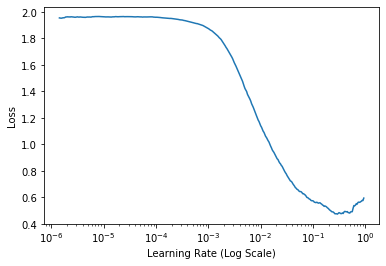

In [26]:
lrf.plot_loss()

In [15]:
cw = joblib.load(BASE_DIR+'class_weights.pkl')
class_weights = {}
for cl in mapp.keys():
    class_weights[ mapp[cl] ] = cw[cl]

print(class_weights)

{0: 9.657731633176741, 1: 8.688168647112235, 2: 8.964115115865935, 3: 9.905649204531997, 4: 8.214835576961036, 5: 4.917295014014449, 6: 9.752082428644744, 7: 9.900122379692867}


In [0]:
subsample = 1
batch_size = 32
train_nb = int(ISIC_TRAIN_SAMPLES/batch_size)+1
val_nb = int(ISIC_VAL_SAMPLES/batch_size)+1

In [0]:
MIN_LR = 1e-3
MAX_LR = 1e-1
STEP_SIZE = 2*train_nb
CLR_METHOD = "triangular2"
clr = CyclicLR(
	mode=CLR_METHOD,
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=STEP_SIZE)

In [0]:
def scheduler(epoch,lr):
    if epoch > 0 and epoch%10==0:
        return lr*0.8
    return lr

In [0]:
filepath="models/ensemble-save-{epoch:02d}-{loss:.3f}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             save_weights_only=True,
                             verbose=1, save_best_only=True, mode='min',
                             period=1)
earlystopping = EarlyStopping(monitor='val_loss',verbose=1,mode='min')
lr_scheduler = LearningRateScheduler(scheduler,verbose=1)
callbacks_list = [checkpoint,earlystopping,clr] #lr_scheduler

In [0]:
ensemble_classifier.compile(optimizer=Adam(lr=MIN_LR),loss='categorical_crossentropy',
                            metrics=['categorical_accuracy'])

In [0]:
train_generator = clf_generator(batch_size,mode='train',subsample=subsample)
val_generator = clf_generator(batch_size,mode='val',subsample=subsample)

In [0]:
epochs = 10

In [0]:
train_history = ensemble_classifier.fit_generator(train_generator,
                                         steps_per_epoch=train_nb,
                                         epochs=epochs,
                                         validation_data = val_generator,
                                         validation_steps = val_nb,
                                         callbacks=callbacks_list,
                                         verbose=1,
                                         initial_epoch=0,
                                         class_weight=class_weights)

Epoch 1/10
  2/634 [..............................] - ETA: 5:42:42 - loss: 15.1794 - categorical_accuracy: 0.0156 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.888724). Check your callbacks.
  % delta_t_median)


555/634 [=========================>....] - ETA: 36:44 - loss: 3.4353 - categorical_accuracy: 0.8499